In [87]:
from pathlib import Path

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

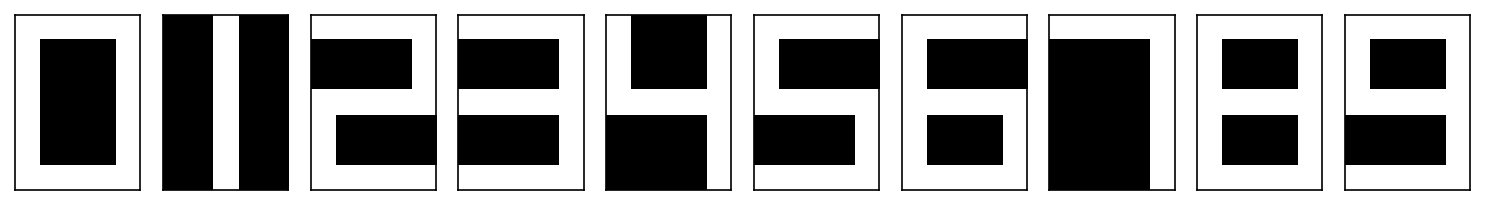

In [88]:
img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [89]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [90]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

In [91]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

In [92]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

In [120]:
# @njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    u = np.zeros((W.shape[0], W.shape[1]))

    Q = 1 - np.eye(W.shape[0])
    
    for i in range(xBatch.shape[0]):
        z = np.ones(W.shape[1])

        for j in range(W.shape[0]):
            u[j] = W[j] @ xBatch[i] + b[j]
            z *= u[j]

        y = softmax(z)

        dLdz = y - yBatch[i]
        q = np.prod(u, axis=0)

        for j in range(W.shape[0]):
            dLdu = dLdz * q / u[j]
            dW[j] += np.outer(dLdu, xBatch[i])
            db[j] += dLdu
        
        # db += dLdz
                        
    return (dW, db)


class WidePerceptron:
    def __init__(self, nIn: int, nL:int, nOut: int) -> None:
        self.nIn = nIn
        self.nL = nL
        self.nOut = nOut
        
        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))
        self.b: np.ndarray = np.zeros((nL, nOut))

    def predict(self, x:np.ndarray) -> np.ndarray:
        u = np.ones(self.nOut)

        for i in range(self.nL):
            u *= self.W[i] @ x + self.b[i]

        return softmax(u)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        y_pred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(y_pred), axis=1)
        return np.mean(h)
    
    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]
        n_batches = n // batch_size

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n_batches):
                ibegin, iend = batch_idx * batch_size, min((batch_idx + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]
            
                dW, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.W, self.b)

                self.W -= lr * dW
                self.b -= lr * db

In [125]:
nIn = 35
nOut = 10
nL = 4

learning_rate = 1e-6
batch_size = 16
max_epoch = 128

model = WidePerceptron(nIn, nL, nOut)

print('untrained loss: {0:.6f}'.format(model.loss(x_test, y_test)))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: {0:.6f}'.format(model.loss(x_test, y_test)))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    y_pred = model.predict(x)
    n_true_pos += 1 if np.argmax(y_pred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss: 8.444569
trained loss: 1.418787
test set accuracy: 10.0%


In [126]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y = model.predict(x)
    n_true_pos += 1 if j == np.argmax(y) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}%")

accuracy: 9.85%


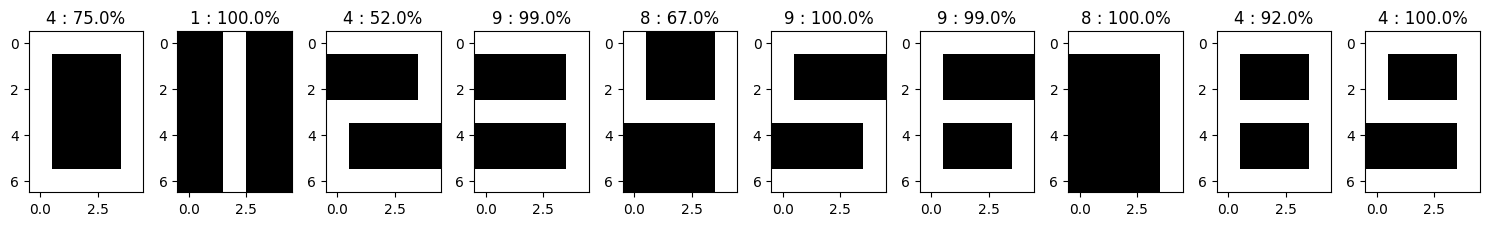

In [128]:
x_noised = data_mtrx + np.random.uniform(0, 0.0, img_size)

yPred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(yPred[i])
    ax.set_title(f"{j} : {(yPred[i][j]*100).round()}%")

plt.autoscale()
plt.tight_layout()
plt.show()

In [97]:
m = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

print(np.prod(m, axis=0))

[ 4 10 18]
